In [5]:
# 0. Imports chuẩn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib

# Optional: XGBoost / LightGBM (cài nếu cần)
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None


Shape: (6398, 19)
Columns: ['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'target']
--- Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             6398 non-null   object 
 1   artist            6398 non-null   object 
 2   uri               6398 non-null   object 
 3   danceability      6398 non-null   float64
 4   energy            6398 non-null   float64
 5   key               6398 non-null   int64  
 6   loudness          6398 non-null   float64
 7   mode              6398 non-null   int64  
 8   speechiness       6398 non-null   float64
 9   acousticness      6398 non-null   float64
 10  instrumentalness  6398 non-null   float64
 11  liveness

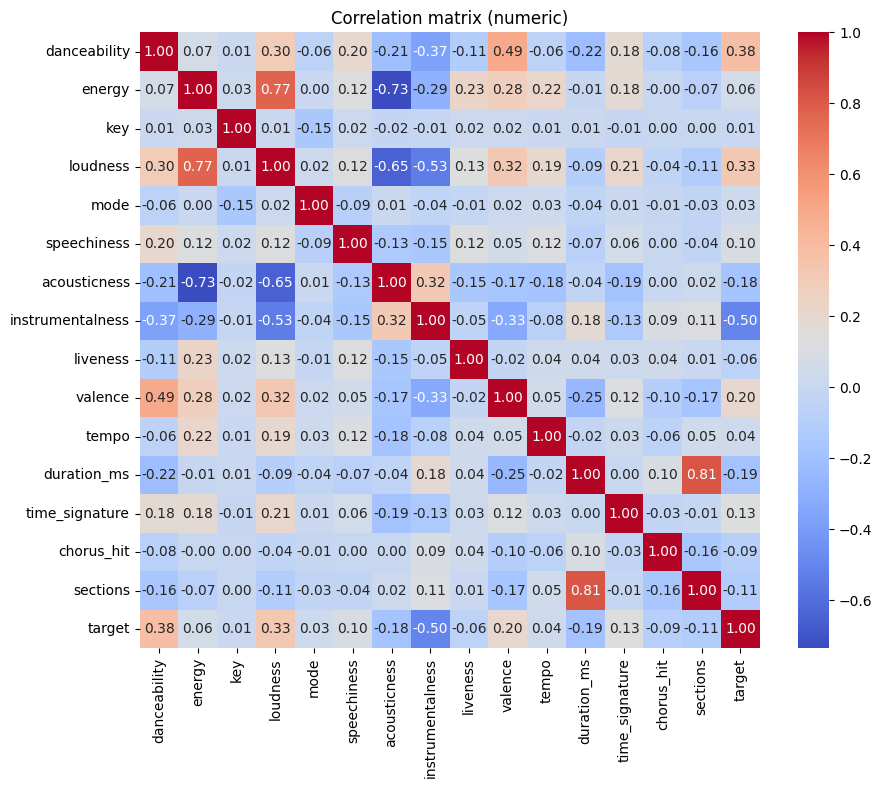

In [7]:
# 1. Load dữ liệu
DATA_PATH = 'dataset-of-10s.csv'  # đảm bảo file nằm cùng thư mục /mnt/data
assert os.path.exists(DATA_PATH), f"Không tìm thấy file {DATA_PATH} — kiểm tra đường dẫn"

data = pd.read_csv(DATA_PATH)

# Hiển thị nhanh
print('Shape:', data.shape)
print('Columns:', data.columns.tolist())
print('--- Info:')
print(data.info())

# 1.1 Kiểm tra missing, phân phối target
print('--- Missing per column')
print(data.isnull().sum())

# Nếu có biến mục tiêu tên 'target' hoặc khác, sửa lại tên dưới đây
TARGET = 'target' if 'target' in data.columns else data.columns[-1]
print('Assumed target:', TARGET)

# Phân phối target
print('Target value counts:')
print(data[TARGET].value_counts())

# 1.2 Thống kê nhanh cho biến số
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)

# Correlation heatmap (numeric only)
if len(num_cols) >= 2:
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[num_cols + [TARGET]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation matrix (numeric)')
    plt.show()


In [9]:
# 2. Preprocessing / pipeline chuẩn
# 2.1 X/y split
X = data.drop(columns=[TARGET])

y = data[TARGET]

# 2.2 Simple preprocessing strategy
# Lưu ý: Từ scikit-learn 1.2 trở lên, tham số 'sparse' của OneHotEncoder đã đổi thành 'sparse_output'
# Nếu bạn gặp lỗi với 'sparse', hãy dùng 'sparse_output' thay thế.
# Nếu dùng scikit-learn <1.2, hãy dùng 'sparse'
# Để code chạy trên cả hai phiên bản, bạn có thể kiểm tra version hoặc chỉ dùng 'sparse_output' nếu chắc chắn version >=1.2

import sklearn
from packaging import version

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
else:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [11]:
# 3. Feature Engineering (các gợi ý và code mẫu)
# Lưu ý: tuỳ dataset mà áp dụng 1-2 kĩ thuật sau.
# 3.1 Tạo biến tương tác đơn giản giữa 2 biến số quan trọng (ví dụ)
# 3.2 Tạo các biến thống kê (mean, std, max, min) theo nhóm nếu có group id
# 3.3 Log-transform cho biến lệch mạnh

# Mình đóng gói vào một hàm để dễ chỉnh

def add_features(df):
    df = df.copy()
    # Ví dụ: log transform cho các cột có phân phối lệch (positives only)
    for c in df.select_dtypes(include=[np.number]).columns:
        if (df[c] > 0).all():
            skew = df[c].skew()
            if abs(skew) > 1.0:
                df[c + '_log'] = np.log1p(df[c])
    # Ví dụ: tạo interaction giữa 2 numeric cột đầu (nếu có ít nhất 2)
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(nums) >= 2:
        df['interaction_01'] = df[nums[0]] * df[nums[1]]
        df['ratio_01'] = df[nums[0]] / (df[nums[1]] + 1e-9)
    # Ví dụ: biến đếm cho categorical
    for c in df.select_dtypes(include=['object', 'category']).columns:
        vc = df[c].value_counts(dropna=False).to_dict()
        df[c + '_count'] = df[c].map(vc)
    return df

# Thử tạo biến mới
X_fe = add_features(X)
print('Sau Feature Engineering shape:', X_fe.shape)

# Update numeric & categorical cols sau khi tạo biến mới
num_cols_fe = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET in num_cols_fe: num_cols_fe.remove(TARGET)
if TARGET in cat_cols_fe: cat_cols_fe.remove(TARGET)


Sau Feature Engineering shape: (6398, 27)


In [15]:
# 4. Feature Selection sơ bộ
# 4.1 SelectKBest (ANOVA / mutual info) — chỉ cho classification
k = min(20, len(num_cols_fe))
if k > 0:
    selector = SelectKBest(score_func=f_classif, k=k)
    # cần impute trước, chỉ áp dụng cho các cột số
    X_num = X_fe[num_cols_fe].fillna(X_fe[num_cols_fe].median())
    selector.fit(X_num, y)
    scores = pd.Series(selector.scores_, index=num_cols_fe)
    scores = scores.sort_values(ascending=False)
    print('Top numeric features by ANOVA:')
    print(scores.head(20))

# 4.2 Model-based feature importance (RandomForest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Chỉ điền giá trị thiếu cho các cột số, tránh lỗi với cột object
X_num_impute = X_fe[num_cols_fe].fillna(X_fe[num_cols_fe].median())
rf.fit(X_num_impute, y)
importances = pd.Series(rf.feature_importances_, index=num_cols_fe)
importances = importances.sort_values(ascending=False)
print('Top importances (RandomForest numeric features):')
print(importances.head(20))


Top numeric features by ANOVA:
instrumentalness    2127.729085
danceability        1109.541673
loudness             768.277866
interaction_01       664.363094
valence              277.091731
duration_ms          237.464382
acousticness         225.341792
artist_count         145.716753
time_signature       105.766628
duration_ms_log       99.793138
sections              83.296132
speechiness           61.745227
speechiness_log       61.714046
chorus_hit            47.197567
sections_log          25.459356
liveness              25.172847
energy                23.653740
uri_count             22.714861
liveness_log          20.675887
tempo                  9.856601
dtype: float64


Top importances (RandomForest numeric features):
instrumentalness    0.233275
loudness            0.076931
acousticness        0.067253
ratio_01            0.063778
danceability        0.062676
energy              0.061954
interaction_01      0.054149
valence             0.042976
duration_ms         0.042935
duration_ms_log     0.042823
artist_count        0.036928
speechiness         0.029549
speechiness_log     0.028497
tempo               0.027674
chorus_hit          0.025463
liveness            0.023639
liveness_log        0.022244
key                 0.015915
sections            0.014751
sections_log        0.013001
dtype: float64


In [ ]:
# 5. Baseline model comparison
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(n_estimators=200, random_state=42),
    'svc': SVC(probability=True)
}
if xgb is not None:
    models['xgb'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
if lgb is not None:
    models['lgbm'] = lgb.LGBMClassifier()

# Pipeline: preprocessor -> model
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    pipe = Pipeline(steps=[('preproc', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X_fe, y, cv=cv, scoring='accuracy')
    results[name] = scores
    print(f"Model {name}: mean acc = {scores.mean():.4f}, std = {scores.std():.4f}")


Model logreg: mean acc = 0.8753, std = 0.0112
Model rf: mean acc = 0.8568, std = 0.0099


In [ ]:
# 6. Tối ưu tham số cho 1 model (ví dụ RandomForest)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}
pipe_rf = Pipeline(steps=[('preproc', preprocessor), ('model', RandomForestClassifier(random_state=42))])
search = GridSearchCV(pipe_rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
search.fit(X_fe, y)
print('
Best RF params:', search.best_params_)
print('Best RF cross-val score:', search.best_score_)

# 6.1 Nếu dataset lớn, dùng RandomizedSearchCV để tiết kiệm thời gian


In [ ]:
# 7. Kiểm tra chéo nâng cao — stability check
best_model = search.best_estimator_
cv_scores = cross_val_score(best_model, X_fe, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=0))
print('Best model 10-fold acc mean/std:', cv_scores.mean(), cv_scores.std())


In [ ]:
# 8. Train/test final split để đánh giá thực tế
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, stratify=y, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print('
Final test accuracy:', accuracy_score(y_test, y_pred))
print('
Classification report:')
print(classification_report(y_test, y_pred))

In [ ]:
# 9. Ensemble — Voting / Stacking example
estimators = []
# train simple estimators
lr = Pipeline(steps=[('preproc', preprocessor), ('model', LogisticRegression(max_iter=1000))])
rf2 = Pipeline(steps=[('preproc', preprocessor), ('model', RandomForestClassifier(n_estimators=200, random_state=42))])

estimators.append(('lr', lr))
estimators.append(('rf', rf2))
if xgb is not None:
    xgb_pipe = Pipeline(steps=[('preproc', preprocessor), ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
    estimators.append(('xgb', xgb_pipe))

voting = VotingClassifier(estimators=estimators, voting='soft')
# Evaluate with cross-val
v_scores = cross_val_score(voting, X_fe, y, cv=cv, scoring='accuracy')
print('
Voting ensemble mean acc:', v_scores.mean(), 'std:', v_scores.std())

In [ ]:
# 10. Lưu model tốt nhất
MODEL_OUT = 'final_model.joblib'
joblib.dump(best_model, MODEL_OUT)
print(f"Saved best model to {MODEL_OUT}")


In [ ]:
# 11. Kết luận & next steps (ghi chú)
"""
Ghi chú:
- Tùy dataset mà cần tinh chỉnh add_features. Không phải mọi kỹ thuật đều áp dụng được.
- Nếu dữ liệu bị mất cân bằng (imbalance), dùng StratifiedKFold, upsampling/SMOTE hoặc metrics như f1/roc_auc.
- Với nhiều biến categorical có nhiều cấp, nên dùng TargetEncoding hoặc CatBoost/LightGBM.
- Sử dụng RandomizedSearchCV nếu lưới param lớn.
- Đối với production: build pipeline hoàn chỉnh (preprocessor + model) và lưu.
"""

print('
Done — đã build sườn cải tiến. Mở canvas để xem mã đầy đủ và chú thích từng bước.')